In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, model_from_json  # type: ignore
from tensorflow.keras.layers import (  # type: ignore
    Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,
)
from tensorflow.keras.optimizers import Adam  # type: ignore
from tensorflow.keras.applications import MobileNetV3Large  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [2]:
# Изменение текущей рабочей директории
os.chdir("../")
%pwd

'/Users/andrejizvarin/Documents/___project/emotion_recognition'

In [3]:
from src.data_loader import DataLoader

# Загрузка данных и разделение на обучающую и валидационную выборки
data_path = "data"
data_loader = DataLoader(data_path)
train_df, val_df = train_test_split(data_loader.labels_df,
                                    test_size=0.2,
                                    random_state=42)

In [11]:
# Функция для подсчета всех файлов в директории и всех ее поддиректориях
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))


# Функция для аугментации изображений
def augment_images(image, label):
    # Применение случайного отражения по горизонтали
    image = tf.image.random_flip_left_right(image)
    # Применение случайного изменения яркости
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Применение случайного изменения контраста
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Применение случайного изменения насыщенности
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    # Применение случайного изменения оттенка
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label


# Функция для подготовки и предобработки данных
def prepare_dataset(dataset_type="train", batch_size=32):
    # Генерация данных из функции load_dataset с batch_size
    dataset = tf.data.Dataset.from_generator(
        lambda: data_loader.load_dataset(dataset_type=dataset_type,
                                         batch_size=batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 9), dtype=tf.float32),
        ),
    )
    # Вычисление общего количества изображений по категориям
    total_images = count_files_in_directory(os.path.join(data_path, "train"))
    # Установка размера буфера перемешивания на 30% от общего количества изображений
    buffer_size = int(total_images * 0.3)
    dataset = dataset.shuffle(buffer_size=buffer_size)
    # Применение аугментации к изображениям
    dataset = dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    # Нормализация изображений после аугментации
    dataset = dataset.map(lambda x, y:
                          (tf.image.per_image_standardization(x), y),
                          num_parallel_calls=tf.data.AUTOTUNE)
    # Предварительная загрузка данных для ускорения обучения
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Повторение данных для обеспечения непрерывной подачи в модель
    dataset = dataset.repeat()
    return dataset


# Создание обучающего и валидационного наборов данных
train_dataset = prepare_dataset(dataset_type="train", batch_size=32)
val_dataset = prepare_dataset(dataset_type="val", batch_size=32)

In [5]:
# Функция для создания модели MobileNetV3
def create_mobilenetv3_model(num_classes=9, fine_tune=False):
    # Загрузка базовой модели MobileNetV3
    base_model = MobileNetV3Large(include_top=False,
                                  weights="imagenet",
                                  input_shape=(224, 224, 3))
    if fine_tune:
        # Разморозка последних 30 слоев для тонкой настройки
        for layer in base_model.layers[-30:]:
            layer.trainable = True
    else:
        # Заморозка всех слоев базовой модели
        base_model.trainable = False

    # Добавление новых слоев
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(1024,
              activation="relu",
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)  # Слой Dropout для предотвращения переобучения
    outputs = Dense(num_classes, activation="softmax")(x)

    # Создание полной модели
    model = Model(inputs=base_model.input, outputs=outputs)

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=0.0001 if fine_tune else 0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


# Создание и компиляция модели
model = create_mobilenetv3_model(num_classes=9, fine_tune=True)

In [6]:
# callback для ранней остановки
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)

# Обучение модели
history = model.fit(train_dataset,
                    epochs=16,
                    steps_per_epoch=len(data_loader.train_df) // 32,
                    validation_data=val_dataset,
                    validation_steps=len(data_loader.val_df) // 32,
                    callbacks=[early_stopping])

Epoch 1/16


2024-05-24 00:17:33.436573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 69 of 15014
2024-05-24 00:17:43.453237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 140 of 15014
2024-05-24 00:18:03.463682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 270 of 15014
2024-05-24 00:18:13.509429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 338 of 15014
2024-05-24 00:18:33.440998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 477 of 15014
2024-05-24 00:18:53.537735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.2560 - loss: 10.6208

2024-05-24 00:36:54.074154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 69 of 15014
2024-05-24 00:37:04.154982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 141 of 15014
2024-05-24 00:37:24.010723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 281 of 15014
2024-05-24 00:37:28.625946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1265s 853ms/step - accuracy: 0.2561 - loss: 10.6195 - val_accuracy: 0.2422 - val_loss: 6.7964
Epoch 2/16
   1/1251 ━━━━━━━━━━━━━━━━━━━━ 16:00 768ms/step - accuracy: 0.4062 - loss: 6.2674

2024-05-24 00:38:28.485495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 67 of 15014
2024-05-24 00:38:38.571208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 139 of 15014
2024-05-24 00:38:58.449805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 273 of 15014
2024-05-24 00:39:08.451366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 341 of 15014
2024-05-24 00:39:28.452062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 480 of 15014
2024-05-24 00:39:38.496110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4533 - loss: 5.3935

2024-05-24 01:28:30.789071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 67 of 15014
2024-05-24 01:28:40.867790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 139 of 15014
2024-05-24 01:29:00.796449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 279 of 15014
2024-05-24 01:29:05.650867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3094s 2s/step - accuracy: 0.4533 - loss: 5.3929 - val_accuracy: 0.3535 - val_loss: 3.7999
Epoch 3/16
   2/1251 ━━━━━━━━━━━━━━━━━━━━ 16:07 775ms/step - accuracy: 0.5234 - loss: 3.4572

2024-05-24 01:30:02.775489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 66 of 15014
2024-05-24 01:30:22.802215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 206 of 15014
2024-05-24 01:30:42.668278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 340 of 15014
2024-05-24 01:30:52.755283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 410 of 15014
2024-05-24 01:31:12.701982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 545 of 15014
2024-05-24 01:31:22.838822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.5346 - loss: 2.9634

2024-05-24 01:49:18.332506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 65 of 15014
2024-05-24 01:49:29.131530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 137 of 15014
2024-05-24 01:49:48.284083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 263 of 15014
2024-05-24 01:49:55.506171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-24 01:49:58.427376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 326 of 15014
2024-05-24 01:50:18.413526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 439 of 15014
2024-05-24 01:50:38.261727: I tensorflow/c

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1249s 999ms/step - accuracy: 0.5346 - loss: 2.9632 - val_accuracy: 0.3593 - val_loss: 2.6409
Epoch 4/16
   3/1251 ━━━━━━━━━━━━━━━━━━━━ 26:01 1s/step - accuracy: 0.5938 - loss: 2.0317

2024-05-24 01:50:51.984442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 56 of 15014
2024-05-24 01:51:02.004498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 122 of 15014
2024-05-24 01:51:18.408415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 805 of 15014
2024-05-24 01:51:30.544366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-24 02:06:44.696130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 931 of 15014
2024-05-24 02:06:54.830231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 996 of 15014
2024-05-24 02:07:08.351478: I tensorflow/c

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5904 - loss: 1.8731

2024-05-24 02:23:55.576851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 53 of 15014
2024-05-24 02:24:15.665586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 168 of 15014
2024-05-24 02:24:25.768724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 224 of 15014


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 2033s 2s/step - accuracy: 0.5904 - loss: 1.8730 - val_accuracy: 0.4363 - val_loss: 1.9943
Epoch 5/16
   4/1251 ━━━━━━━━━━━━━━━━━━━━ 15:38 752ms/step - accuracy: 0.5130 - loss: 1.6921

2024-05-24 02:24:45.552897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 341 of 15014
2024-05-24 02:24:55.595383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 411 of 15014
2024-05-24 02:25:15.573635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 550 of 15014
2024-05-24 02:25:25.642449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 621 of 15014
2024-05-24 02:25:45.596381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 755 of 15014
2024-05-24 02:26:05.652668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a w

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6500 - loss: 1.3452

2024-05-24 04:04:01.752239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 45 of 15014
2024-05-24 04:04:11.769351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 71 of 15014
2024-05-24 04:04:22.814106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 148 of 15014
2024-05-24 04:04:32.835057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 218 of 15014
2024-05-24 04:04:42.862467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 284 of 15014
2024-05-24 04:04:47.207579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-24 04:04:54.646201: I tensorflow/co

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6057s 5s/step - accuracy: 0.6499 - loss: 1.3452 - val_accuracy: 0.4608 - val_loss: 1.8010
Epoch 6/16
   1/1251 ━━━━━━━━━━━━━━━━━━━━ 34:30 2s/step - accuracy: 0.6562 - loss: 1.2866

2024-05-24 04:05:34.682378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 618 of 15014


   5/1251 ━━━━━━━━━━━━━━━━━━━━ 19:45 951ms/step - accuracy: 0.5970 - loss: 1.3765

2024-05-24 04:05:52.028428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 124 of 15014
2024-05-24 04:06:04.678188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 813 of 15014
2024-05-24 04:06:19.607989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-24 04:06:24.668073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 950 of 15014
2024-05-24 04:12:44.590237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1091 of 15014
2024-05-24 04:13:04.638635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1227 of 15014
2024-05-24 04:13:08.491123: I tensorflo

1238/1251 ━━━━━━━━━━━━━━━━━━━━ 1:31 7s/step - accuracy: 0.7131 - loss: 1.0296

2024-05-24 06:31:09.884238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 51 of 15014


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7130 - loss: 1.0296

2024-05-24 06:31:19.920646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 108 of 15014
2024-05-24 06:31:40.015018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 219 of 15014
2024-05-24 06:31:59.849645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 331 of 15014


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 8793s 7s/step - accuracy: 0.7130 - loss: 1.0296 - val_accuracy: 0.4707 - val_loss: 1.7986
Epoch 7/16
   5/1251 ━━━━━━━━━━━━━━━━━━━━ 17:09 826ms/step - accuracy: 0.7136 - loss: 0.9601

2024-05-24 06:32:09.976635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 386 of 15014


   6/1251 ━━━━━━━━━━━━━━━━━━━━ 17:00 820ms/step - accuracy: 0.7110 - loss: 0.9583

2024-05-24 06:32:20.133103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 451 of 15014
2024-05-24 06:32:35.004021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 192 of 15014
2024-05-24 06:32:49.993053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 650 of 15014
2024-05-24 06:32:53.199238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-24 06:33:10.025373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 785 of 15014
2024-05-24 06:33:29.963167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 926 of 15014
2024-05-24 06:37:14.196030: I tensorflow/

1207/1251 ━━━━━━━━━━━━━━━━━━━━ 4:22 6s/step - accuracy: 0.7890 - loss: 0.7870

2024-05-24 08:31:53.706550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 51 of 15014


1210/1251 ━━━━━━━━━━━━━━━━━━━━ 4:03 6s/step - accuracy: 0.7890 - loss: 0.7870

2024-05-24 08:44:27.189845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 61 of 15014


1223/1251 ━━━━━━━━━━━━━━━━━━━━ 3:02 7s/step - accuracy: 0.7889 - loss: 0.7871

2024-05-24 08:44:37.310478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 117 of 15014


1244/1251 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.7888 - loss: 0.7873

2024-05-24 08:44:53.658298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 200 of 15014


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7887 - loss: 0.7874

2024-05-24 08:45:03.851295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 255 of 15014
2024-05-24 08:45:23.927091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 366 of 15014
2024-05-24 08:45:43.657094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 480 of 15014


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 8020s 6s/step - accuracy: 0.7887 - loss: 0.7874 - val_accuracy: 0.4503 - val_loss: 2.0488
Epoch 8/16
   7/1251 ━━━━━━━━━━━━━━━━━━━━ 18:03 871ms/step - accuracy: 0.7449 - loss: 0.7972

2024-05-24 08:45:53.761977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 534 of 15014
2024-05-24 08:46:03.785711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 603 of 15014
2024-05-24 08:46:15.418782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 190 of 15014
2024-05-24 08:49:03.008363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 778 of 15014
2024-05-24 08:49:06.645924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-24 08:49:13.777455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 848 of 15014
2024-05-24 08:49:33.684965: I tensorflow/

1142/1251 ━━━━━━━━━━━━━━━━━━━━ 6:10 3s/step - accuracy: 0.8507 - loss: 0.5923

2024-05-24 09:50:24.963594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 39 of 15014


1165/1251 ━━━━━━━━━━━━━━━━━━━━ 4:48 3s/step - accuracy: 0.8505 - loss: 0.5926

2024-05-24 09:50:44.914987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 118 of 15014


1176/1251 ━━━━━━━━━━━━━━━━━━━━ 4:09 3s/step - accuracy: 0.8504 - loss: 0.5927

2024-05-24 09:50:54.952415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 155 of 15014


1199/1251 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - accuracy: 0.8502 - loss: 0.5930

2024-05-24 09:51:15.048393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 231 of 15014


1220/1251 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - accuracy: 0.8500 - loss: 0.5934

2024-05-24 09:51:35.032846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 306 of 15014


1242/1251 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8498 - loss: 0.5937

2024-05-24 09:51:54.968249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 383 of 15014


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8497 - loss: 0.5939

2024-05-24 09:52:14.895194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 457 of 15014
2024-05-24 09:52:24.933182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 498 of 15014
2024-05-24 09:52:35.000167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 539 of 15014
2024-05-24 09:52:54.882676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 619 of 15014


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 4036s 3s/step - accuracy: 0.8497 - loss: 0.5939 - val_accuracy: 0.4531 - val_loss: 2.2719
Epoch 9/16
   8/1251 ━━━━━━━━━━━━━━━━━━━━ 19:18 932ms/step - accuracy: 0.8178 - loss: 0.7281

2024-05-24 09:53:14.892720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 711 of 15014
2024-05-24 09:53:34.781001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 847 of 15014
2024-05-24 09:53:44.899610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 918 of 15014
2024-05-24 09:53:54.939191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 988 of 15014
2024-05-24 09:54:14.844805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1127 of 15014
2024-05-24 09:54:24.853975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a 

1014/1251 ━━━━━━━━━━━━━━━━━━━━ 3:56 997ms/step - accuracy: 0.8997 - loss: 0.4509

2024-05-24 10:09:53.308638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34 of 15014


1034/1251 ━━━━━━━━━━━━━━━━━━━━ 3:36 996ms/step - accuracy: 0.8996 - loss: 0.4512

2024-05-24 10:10:13.132057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 101 of 15014


1054/1251 ━━━━━━━━━━━━━━━━━━━━ 3:16 997ms/step - accuracy: 0.8994 - loss: 0.4514

2024-05-24 10:10:33.093682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 165 of 15014


1064/1251 ━━━━━━━━━━━━━━━━━━━━ 3:06 997ms/step - accuracy: 0.8994 - loss: 0.4516

2024-05-24 10:10:43.170310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 196 of 15014


1074/1251 ━━━━━━━━━━━━━━━━━━━━ 2:56 997ms/step - accuracy: 0.8993 - loss: 0.4517

2024-05-24 10:10:53.172241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 15014


1092/1251 ━━━━━━━━━━━━━━━━━━━━ 2:38 998ms/step - accuracy: 0.8992 - loss: 0.4520

2024-05-24 10:11:13.089531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 288 of 15014


1102/1251 ━━━━━━━━━━━━━━━━━━━━ 2:28 999ms/step - accuracy: 0.8991 - loss: 0.4521

2024-05-24 10:11:23.193276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 318 of 15014


1121/1251 ━━━━━━━━━━━━━━━━━━━━ 2:09 1000ms/step - accuracy: 0.8990 - loss: 0.4523

2024-05-24 10:11:43.208750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 380 of 15014


1139/1251 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.8988 - loss: 0.4526

2024-05-24 10:12:03.093651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 438 of 15014


1148/1251 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.8988 - loss: 0.4527

2024-05-24 10:12:13.120367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 469 of 15014


1157/1251 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.8987 - loss: 0.4528

2024-05-24 10:12:23.213791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 of 15014


1175/1251 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.8986 - loss: 0.4531

2024-05-24 10:12:43.029732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 558 of 15014


1184/1251 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.8985 - loss: 0.4532

2024-05-24 10:12:53.052056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 589 of 15014


1193/1251 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8984 - loss: 0.4533

2024-05-24 10:13:03.057186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 617 of 15014


1202/1251 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8984 - loss: 0.4535

2024-05-24 10:13:13.391520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 646 of 15014


1219/1251 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8982 - loss: 0.4537

2024-05-24 10:13:33.348570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 704 of 15014


1237/1251 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8981 - loss: 0.4540

2024-05-24 10:13:53.335886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 760 of 15014


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8980 - loss: 0.4543

2024-05-24 10:14:13.038161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 823 of 15014
2024-05-24 10:14:23.110587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 889 of 15014
2024-05-24 10:14:33.124422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 956 of 15014
2024-05-24 10:14:48.889573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 253 of 15014
2024-05-24 10:14:58.365766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-24 10:15:03.293136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1133 of 15014
2024-05-24 10:15:23.096607: I tensorflow

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1391s 1s/step - accuracy: 0.8980 - loss: 0.4543 - val_accuracy: 0.3578 - val_loss: 3.0281


In [7]:
# Оценка модели на обучающем наборе данных
val_loss, val_accuracy = model.evaluate(train_dataset, steps=50)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

2024-05-24 10:16:23.753753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 68 of 15014
2024-05-24 10:16:33.755882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 140 of 15014
2024-05-24 10:16:43.777799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 208 of 15014
2024-05-24 10:17:03.751397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 344 of 15014
2024-05-24 10:17:23.718319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 484 of 15014
2024-05-24 10:17:43.791211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a wh

50/50 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.7083 - loss: 1.0068
Validation Accuracy: 70.56%


In [8]:
# Сохранение модели
model.save("models/mobilenet_v3.keras")

In [9]:
# Загрузка сохраненной модели
model_path = "models/mobilenet_v3.keras"
model = load_model(model_path)

# Подготовка данных для оценки
val_dataset = prepare_dataset(dataset_type="val", batch_size=32)
true_labels = []
predictions = []

# Итерация по валидационному набору данных и сбор меток и предсказаний
for images, labels in val_dataset.take(len(data_loader.val_df) // 32):
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    labels = np.argmax(labels.numpy(), axis=1)
    true_labels.extend(labels)
    predictions.extend(preds)

# Вычисление и вывод метрик
print("Classification Report:")
print(classification_report(true_labels, predictions))
print("Accuracy:", accuracy_score(true_labels, predictions))
print("F1 Score (macro):", f1_score(true_labels, predictions, average="macro"))

2024-05-24 10:23:05.979873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:39: Filling up shuffle buffer (this may take a while): 71 of 15014
2024-05-24 10:23:16.016942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:39: Filling up shuffle buffer (this may take a while): 145 of 15014
2024-05-24 10:23:36.032833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:39: Filling up shuffle buffer (this may take a while): 291 of 15014
2024-05-24 10:39:25.637589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:39: Filling up shuffle buffer (this may take a while): 299 of 15014
2024-05-24 10:39:27.767094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-05-24 10:44:03.550904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


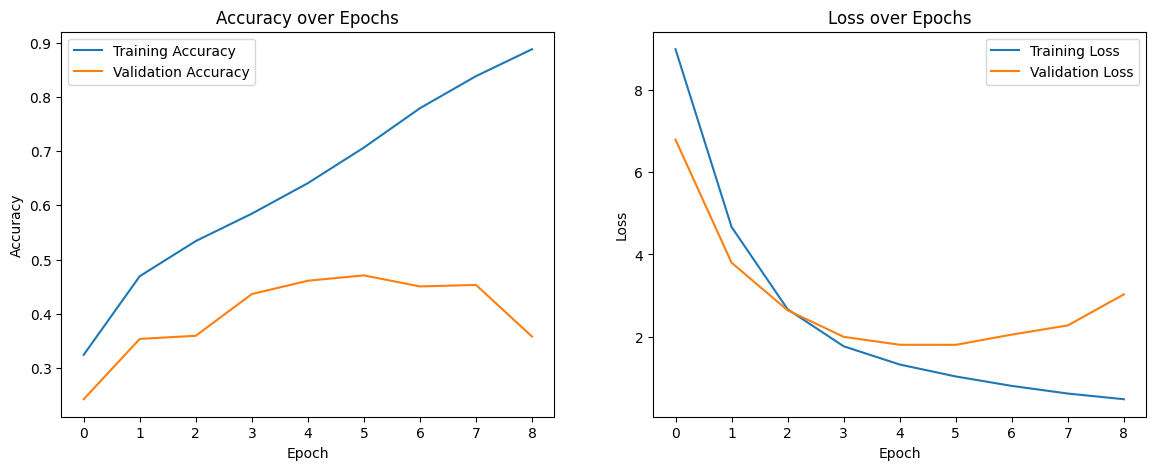

In [10]:
# Функция для построения графиков обучения
def plot_training_history(history):
    # Создание фигуры с двумя подграфиками
    plt.figure(figsize=(14, 5))

    # Подграфик для точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Подграфик для потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(label='Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Отображение графиков
    plt.show()


# Вызов функции для построения графиков обучения
plot_training_history(history)